Loading data from /kaggle/input/datasetimbh/catalog_converted.csv...
Original features: ['Mass', 'M/L', 'Core radius', 'Rhm', 'Core density', 'Densityhm', 'Trh', 'Vdispersion', 'Vesc']

Checking for skewed features...
  -> Applied Log Transform to 'Mass' (Skewness: 13.02)
  -> Applied Log Transform to 'M/L' (Skewness: 5.61)
  -> Applied Log Transform to 'Core radius' (Skewness: 2.50)
  -> Applied Log Transform to 'Rhm' (Skewness: 2.55)
  -> Applied Log Transform to 'Core density' (Skewness: 1.20)
  -> Applied Log Transform to 'Vdispersion' (Skewness: 3.20)
  -> Applied Log Transform to 'Vesc' (Skewness: 3.34)

Running Improved Ensemble Detection...

Analysis Complete.
Total Datapoints: 578
Outliers Detected: 17

TOP DETECTED OUTLIERS (Ranked by Deviation)
• BSDL_103
  Anomaly Score:      4.12 sigma (Deviation from median)
  Ensemble Consensus: 3/3 Models Agreed
  Primary Reason:     'M/L' is extreme
--------------------------------------------------
• B023-G078
  Anomaly Score:      3.

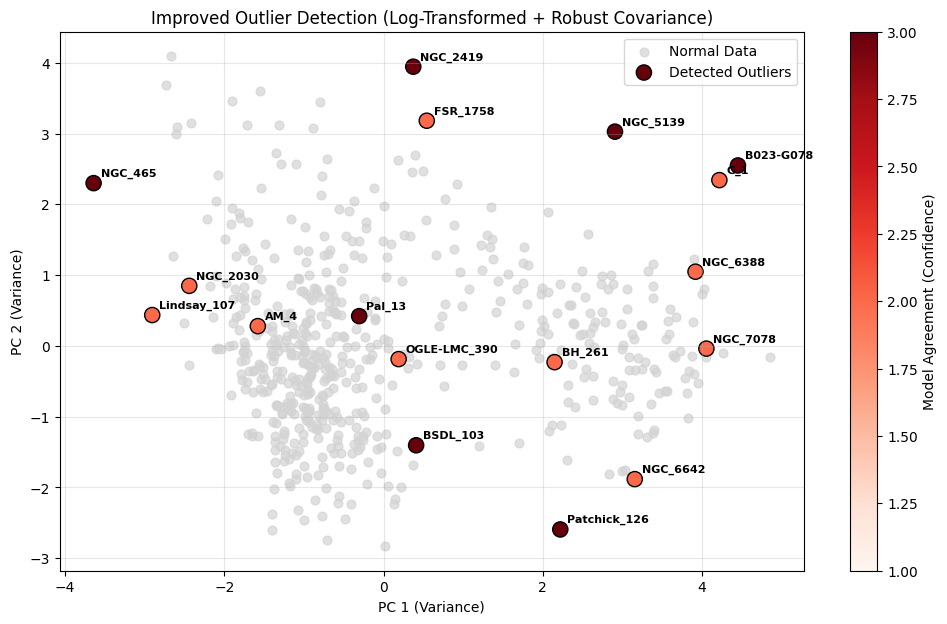

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from scipy.stats import skew

def detect_outliers(file_path):
    # 1. Load Data
    print(f"Loading data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("Error: File not found. Please check the path.")
        return

    # 2. Preprocessing
    # Filter only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude ID columns
    if 'Unnamed: 0' in numeric_cols:
        numeric_cols.remove('Unnamed: 0')
    
    print(f"Original features: {numeric_cols}")
    X_original = df[numeric_cols].copy()
    
    # --- IMPROVEMENT 1: Handle Missing Values ---
    imputer = SimpleImputer(strategy='median')
    X_filled = pd.DataFrame(imputer.fit_transform(X_original), columns=numeric_cols)

    # --- IMPROVEMENT 2: Log-Transform Skewed Features ---
    # Physical data (Mass, Density) often spans orders of magnitude. 
    # We log-transform features with high skew (> 1) to make distribution more normal.
    X_transformed = X_filled.copy()
    print("\nChecking for skewed features...")
    for col in numeric_cols:
        # Check skewness (drop NaNs for calculation)
        s = skew(X_filled[col].dropna())
        if abs(s) > 1.0:
            # Shift by min value if negative to allow log
            min_val = X_filled[col].min()
            shift = abs(min_val) + 1 if min_val <= 0 else 0
            
            X_transformed[col] = np.log1p(X_filled[col] + shift)
            print(f"  -> Applied Log Transform to '{col}' (Skewness: {s:.2f})")

    # Scale Data (RobustScaler is still best for outliers)
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_transformed)

    # 3. Define Algorithms (Updated for Better Performance)
    contamination = 0.05 
    
    classifiers = {
        # Good for global anomalies
        "Isolation Forest": IsolationForest(
            n_estimators=100, 
            contamination=contamination, 
            random_state=42
        ),
        # Good for local density anomalies
        "Local Outlier Factor": LocalOutlierFactor(
            n_neighbors=min(20, len(df)//2), 
            contamination=contamination
        ),
        # --- IMPROVEMENT 3: Elliptic Envelope ---
        # Fits a robust Gaussian covariance. excellent for physical data 
        # that should theoretically form a coherent cloud/cluster.
        "Robust Covariance (Elliptic)": EllipticEnvelope(
            support_fraction=0.8, # Use 80% of data to fit the ellipse
            contamination=contamination,
            random_state=42
        )
    }

    # 4. Run Detection
    results = pd.DataFrame(index=df.index)
    
    print("\nRunning Improved Ensemble Detection...")
    for clf_name, clf in classifiers.items():
        try:
            if clf_name == "Local Outlier Factor":
                y_pred = clf.fit_predict(X_scaled)
            else:
                clf.fit(X_scaled)
                y_pred = clf.predict(X_scaled)
            
            # Map: -1 (outlier) -> 1, 1 (inlier) -> 0
            results[clf_name] = [1 if x == -1 else 0 for x in y_pred]
        except Exception as e:
            print(f"Warning: {clf_name} failed: {e}")
            results[clf_name] = 0

    # 5. Consensus Voting
    results['Vote_Sum'] = results.sum(axis=1)
    results['Is_Outlier'] = results['Vote_Sum'] >= 2 # Majority vote

    # Add results back
    df_out = df.copy()
    df_out['is_outlier'] = results['Is_Outlier']
    df_out['model_votes'] = results['Vote_Sum']

    # 6. Report & Explain
    outliers = df_out[df_out['is_outlier'] == True]
    print(f"\nAnalysis Complete.")
    print(f"Total Datapoints: {len(df)}")
    print(f"Outliers Detected: {len(outliers)}")
    
    if len(outliers) > 0:
        print("\n" + "="*50)
        print("TOP DETECTED OUTLIERS (Ranked by Deviation)")
        print("="*50)
        
        # --- IMPROVEMENT 4: Explainability ---
        # Calculate Z-scores on scaled data to see WHICH feature is weird
        X_zscore = pd.DataFrame(X_scaled, columns=numeric_cols, index=df.index)
        
        # Sort outliers by their maximum deviation (most anomalous first)
        outlier_indices = outliers.index
        max_deviations = X_zscore.loc[outlier_indices].abs().max(axis=1)
        sorted_indices = max_deviations.sort_values(ascending=False).index

        for idx in sorted_indices:
            # Find feature with max absolute deviation for this point
            row_z = X_zscore.loc[idx].abs()
            top_reason = row_z.idxmax()
            score = row_z.max()
            votes = df_out.loc[idx, 'model_votes']
            
            name = df.loc[idx, 'Cluster'] if 'Cluster' in df.columns else f"Index {idx}"
            
            print(f"• {name}")
            print(f"  Anomaly Score:      {score:.2f} sigma (Deviation from median)")
            print(f"  Ensemble Consensus: {votes}/3 Models Agreed")
            print(f"  Primary Reason:     '{top_reason}' is extreme")
            print("-" * 50)
            
            # Add score to dataframe for export
            df_out.loc[idx, 'max_deviation_score'] = score

        # Save to CSV
        output_file = 'outlier_analysis_results.csv'
        df_out.to_csv(output_file, index=False)
        print(f"\nFull results saved to {output_file}")

    # 7. Visualization (PCA)
    if len(df) > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        plt.figure(figsize=(12, 7))
        
        # Plot inliers
        inliers_idx = ~results['Is_Outlier']
        plt.scatter(X_pca[inliers_idx, 0], X_pca[inliers_idx, 1], 
                   c='lightgray', alpha=0.7, label='Normal Data', s=40)
        
        # Plot outliers
        outliers_idx = results['Is_Outlier']
        scatter = plt.scatter(X_pca[outliers_idx, 0], X_pca[outliers_idx, 1], 
                   c=results.loc[outliers_idx, 'Vote_Sum'], cmap='Reds', 
                   label='Detected Outliers', s=120, edgecolors='black', vmin=1, vmax=3)
        
        plt.colorbar(scatter, label='Model Agreement (Confidence)')
        plt.title('Improved Outlier Detection (Log-Transformed + Robust Covariance)')
        plt.xlabel('PC 1 (Variance)')
        plt.ylabel('PC 2 (Variance)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if len(outliers) < 30 and 'Cluster' in df.columns:
            for idx in outliers.index:
                plt.annotate(df.loc[idx, 'Cluster'], 
                             (X_pca[idx, 0], X_pca[idx, 1]),
                             xytext=(5, 5), textcoords='offset points', fontsize=8, weight='bold')
        
        plt.savefig('outlier_visualization.png')
        print("Visualization saved as outlier_visualization.png")
        plt.show()

if __name__ == "__main__":
    detect_outliers('/kaggle/input/datasetimbh/catalog_converted.csv')